In [161]:
# !sudo apt install ros-noetic-foxglove-msgs
# !pip install nuscenes-devkit
# !python3 -m pip install --user git+https://github.com/DanielPollithy/pypcd.git
# !wget -N https://www.nuscenes.org/data/v1.0-mini.tgz
# !mkdir -p data
# !tar -xzf v1.0-mini.tgz -C data

In [3]:
from diagnostic_msgs.msg import DiagnosticArray, DiagnosticStatus, KeyValue
from foxglove_msgs.msg import ImageMarkerArray
from geometry_msgs.msg import Point, Pose, PoseStamped, Transform, TransformStamped
from matplotlib import pyplot as plt
from nav_msgs.msg import OccupancyGrid, Odometry
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from nuscenes.eval.common.utils import quaternion_yaw
from nuscenes.map_expansion.bitmap import BitMap
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.nuscenes import NuScenes
from pprint import pprint
from pypcd import numpy_pc2, pypcd
from pyquaternion import Quaternion
from sensor_msgs.msg import CameraInfo, CompressedImage, Imu, NavSatFix, PointCloud2, PointField
from sensor_msgs.msg import PointCloud2
from std_msgs.msg import ColorRGBA
from tf2_msgs.msg import TFMessage
from typing import List, Tuple, Dict
from visualization_msgs.msg import ImageMarker, Marker, MarkerArray

import math
import numpy as np
import os
import random
import rosbag
import rospy
import seaborn as sns

In [4]:
nusc = NuScenes(version='v1.0-mini', dataroot='data', verbose=True)
nusc_can = NuScenesCanBus(dataroot='data')

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 panoptic,
Done loading in 0.616 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [13]:
scene = nusc.scene[0]
scene_name = scene['name']

log = nusc.get('log', scene['log_token'])
nusc_map = NuScenesMap(dataroot='data', map_name=log['location'])

print(scene_name)
print(nusc_map.canvas_edge)

scene-0061
[1585.6, 2025.0]


In [14]:
bitmap = BitMap(nusc_map.dataroot, nusc_map.map_name, 'basemap')
print(bitmap.image.shape)

(20250, 15856)


In [5]:
nusc.get('sample', scene['first_sample_token'])

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [6]:
nusc.get('sample_data', nusc.get('sample', scene['first_sample_token'])['data']['LIDAR_TOP'])

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402927647951,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin',
 'prev': '',
 'next': '0cedf1d2d652468d92d23491136b5d15',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [128]:
EARTH_RADIUS_METERS = 6.378137e6
REFERENCE_COORDINATES = {
    "boston-seaport": [42.336849169438615, -71.05785369873047],
    "singapore-onenorth": [1.2882100868743724, 103.78475189208984],
    "singapore-hollandvillage": [1.2993652317780957, 103.78217697143555],
    "singapore-queenstown": [1.2782562240223188, 103.76741409301758],
}

def get_coordinate(ref_lat: float, ref_lon: float, bearing: float, dist: float) -> Tuple[float, float]:
    """
    Using a reference coordinate, extract the coordinates of another point in space given its distance and bearing
    to the reference coordinate. For reference, please see: https://www.movable-type.co.uk/scripts/latlong.html.
    :param ref_lat: Latitude of the reference coordinate in degrees, ie: 42.3368.
    :param ref_lon: Longitude of the reference coordinate in degrees, ie: 71.0578.
    :param bearing: The clockwise angle in radians between target point, reference point and the axis pointing north.
    :param dist: The distance in meters from the reference point to the target point.
    :return: A tuple of lat and lon.
    """
    lat, lon = math.radians(ref_lat), math.radians(ref_lon)
    angular_distance = dist / EARTH_RADIUS_METERS

    target_lat = math.asin(
        math.sin(lat) * math.cos(angular_distance) + 
        math.cos(lat) * math.sin(angular_distance) * math.cos(bearing)
    )
    target_lon = lon + math.atan2(
        math.sin(bearing) * math.sin(angular_distance) * math.cos(lat),
        math.cos(angular_distance) - math.sin(lat) * math.sin(target_lat)
    )
    return math.degrees(target_lat), math.degrees(target_lon)

def derive_latlon(location: str, pose: Dict[str, float]):
    """
    For each pose value, extract its respective lat/lon coordinate and timestamp.
    
    This makes the following two assumptions in order to work:
        1. The reference coordinate for each map is in the south-western corner.
        2. The origin of the global poses is also in the south-western corner (and identical to 1).
    :param location: The name of the map the poses correspond to, ie: 'boston-seaport'.
    :param poses: All nuScenes egopose dictionaries of a scene.
    :return: A list of dicts (lat/lon coordinates and timestamps) for each pose.
    """
    assert location in REFERENCE_COORDINATES.keys(), \
        f'Error: The given location: {location}, has no available reference.'

    coordinates = []
    reference_lat, reference_lon = REFERENCE_COORDINATES[location]
    ts = pose['timestamp']
    x, y = pose['translation'][:2]
    bearing = math.atan(x / y)
    distance = math.sqrt(x**2 + y**2)
    lat, lon = get_coordinate(reference_lat, reference_lon, bearing, distance)
    return {'latitude': lat, 'longitude': lon}

def get_transform(data):
    t = Transform()
    t.translation.x = data['translation'][0]
    t.translation.y = data['translation'][1]
    t.translation.z = data['translation'][2]
    
    t.rotation.w = data['rotation'][0]
    t.rotation.x = data['rotation'][1]
    t.rotation.y = data['rotation'][2]
    t.rotation.z = data['rotation'][3]
    
    return t

def get_pose(data):
    p = Pose()
    p.position.x = data['translation'][0]
    p.position.y = data['translation'][1]
    p.position.z = data['translation'][2]
    
    p.orientation.w = data['rotation'][0]
    p.orientation.x = data['rotation'][1]
    p.orientation.y = data['rotation'][2]
    p.orientation.z = data['rotation'][3]
    
    return p

def get_time(data):
    t = rospy.Time()
    t.secs, msecs = divmod(data['timestamp'], 1_000_000)
    t.nsecs = msecs * 1000

    return t

def get_utime(data):
    t = rospy.Time()
    t.secs, msecs = divmod(data['utime'], 1_000_000)
    t.nsecs = msecs * 1000

    return t

def make_point(xyz):
    p = Point()
    p.x = xyz[0]
    p.y = xyz[1]
    p.z = xyz[2]
    return p

def make_point2d(xy):
    p = Point()
    p.x = xy[0]
    p.y = xy[1]
    p.z = 0.0
    return p

def make_color(rgb, a=1):
    c = ColorRGBA()
    c.r = rgb[0]
    c.g = rgb[1]
    c.b = rgb[2]
    c.a = a
    
    return c

turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]

def turbomap(x):
  colormap = turbo_colormap_data
  x = max(0.0, min(1.0, x))
  a = int(x*255.0)
  b = min(255, a + 1)
  f = x*255.0 - a
  return [colormap[a][0] + (colormap[b][0] - colormap[a][0]) * f,
          colormap[a][1] + (colormap[b][1] - colormap[a][1]) * f,
          colormap[a][2] + (colormap[b][2] - colormap[a][2]) * f]

def get_categories(first_sample):
    published_samples = set()
    categories = set()
    sample_lidar = first_sample
    while sample_lidar is not None:
        sample = nusc.get('sample', sample_lidar['sample_token'])
        if sample['token'] not in published_samples:
            for annotation_id in sample['anns']:
                ann = nusc.get('sample_annotation', annotation_id)
                categories.add(ann['category_name'])
        sample_lidar = nusc.get('sample_data', sample_lidar['next']) if sample_lidar.get('next') != '' else None
    return categories

def write_radar(bag, sample_data, frame_id, topic, stamp):
    pc_filename = 'data/' + sample_data['filename']
    pc = pypcd.PointCloud.from_path(pc_filename)
    msg = numpy_pc2.array_to_pointcloud2(pc.pc_data)
    msg.header.frame_id = frame_id
    msg.header.stamp = get_time(sample_data)
    bag.write(topic, msg, stamp)

def write_camera(bag, sample_data, frame_id, topic_ns, stamp):
    jpg_filename = 'data/' + sample_data['filename']
    msg = CompressedImage()
    msg.header.frame_id = frame_id
    msg.header.stamp = get_time(sample_data)
    msg.format = "jpeg"
    with open(jpg_filename, 'rb') as jpg_file:
        msg.data = jpg_file.read()
    bag.write(topic_ns + '/image_rect_compressed', msg, stamp)

    calib = nusc.get('calibrated_sensor', sample_data['calibrated_sensor_token'])

    msg_info = CameraInfo()
    msg_info.header.frame_id = frame_id
    msg_info.header.stamp = msg.header.stamp
    msg_info.height = sample_data['height']
    msg_info.width = sample_data['width']
    msg_info.K[0] = calib['camera_intrinsic'][0][0]
    msg_info.K[1] = calib['camera_intrinsic'][0][1]
    msg_info.K[2] = calib['camera_intrinsic'][0][2]
    msg_info.K[3] = calib['camera_intrinsic'][1][0]
    msg_info.K[4] = calib['camera_intrinsic'][1][1]
    msg_info.K[5] = calib['camera_intrinsic'][1][2]
    msg_info.K[6] = calib['camera_intrinsic'][2][0]
    msg_info.K[7] = calib['camera_intrinsic'][2][1]
    msg_info.K[8] = calib['camera_intrinsic'][2][2]
    
    msg_info.R[0] = 1
    msg_info.R[3] = 1
    msg_info.R[6] = 1
    
    msg_info.P[0] = msg_info.K[0]
    msg_info.P[1] = msg_info.K[1]
    msg_info.P[2] = msg_info.K[2]
    msg_info.P[3] = 0
    msg_info.P[4] = msg_info.K[3]
    msg_info.P[5] = msg_info.K[4]
    msg_info.P[6] = msg_info.K[5]
    msg_info.P[7] = 0
    msg_info.P[8] = 0
    msg_info.P[9] = 0
    msg_info.P[10] = 1
    msg_info.P[11] = 0
    bag.write(topic_ns + '/camera_info', msg_info, stamp)

def write_lidar(bag, sample_data, frame_id, topic, stamp):
    pc_filename = 'data/' + sample_data['filename']
    pc_filesize = os.stat(pc_filename).st_size

    with open(pc_filename, 'rb') as pc_file:
        msg = PointCloud2()
        msg.header.frame_id = frame_id
        msg.header.stamp = get_time(sample_data)

        msg.fields = [
            PointField(name='x', offset=0, datatype=PointField.FLOAT32, count=1),
            PointField(name='y', offset=4, datatype=PointField.FLOAT32, count=1),
            PointField(name='z', offset=8, datatype=PointField.FLOAT32, count=1),
            PointField(name='intensity', offset=12, datatype=PointField.FLOAT32, count=1),
            PointField(name='ring', offset=16, datatype=PointField.FLOAT32, count=1),
        ]

        msg.is_bigendian = False
        msg.is_dense = True
        msg.point_step = len(msg.fields) * 4 # 4 bytes per field
        msg.row_step = pc_filesize
        msg.width = round(pc_filesize / msg.point_step)
        msg.height = 1 # unordered
        msg.data = pc_file.read()

        bag.write(topic, msg, stamp)

def write_lidar_imagemarkers(bag, sample_lidar, sample_data, frame_id, topic_ns, stamp):
    # lidar image markers in camera frame
    points, coloring, _ = nusc.explorer.map_pointcloud_to_image(
        pointsensor_token=sample_lidar['token'],
        camera_token=sample_data['token'],
        render_intensity=True)
    points = points.transpose()
    coloring = [turbomap(c) for c in coloring]

    marker = ImageMarker()
    marker.header.frame_id = sensor_id
    marker.header.stamp = get_time(sample_data)
    marker.ns = 'LIDAR_TOP'
    marker.id = 0
    marker.type = ImageMarker.POINTS
    marker.action = ImageMarker.ADD
    marker.scale = 2.0
    marker.points = [make_point2d(p) for p in points]
    marker.outline_colors = [make_color(c) for c in coloring]

    msg = ImageMarkerArray()
    msg.markers = [marker]

    bag.write(topic_ns + '/image_markers_lidar', msg, stamp)

def write_boxes_imagemarkers(bag, anns, sample_data, frame_id, topic_ns, stamp):
    # annotation boxes
    collector = Collector()
    _, boxes, camera_intrinsic = nusc.get_sample_data(sample_data['token'])
    for box in boxes:
        c = np.array(nusc.explorer.get_color(box.name)) / 255.0
        box.render(collector, view=camera_intrinsic, normalize=True, colors=(c, c, c))

    marker = ImageMarker()
    marker.header.frame_id = sensor_id
    marker.header.stamp = get_time(sample_data)
    marker.ns = 'annotations'
    marker.id = 0
    marker.type = ImageMarker.LINE_LIST
    marker.action = ImageMarker.ADD
    marker.scale = 2.0
    marker.points = [make_point2d(p) for p in collector.points]
    marker.outline_colors = [make_color(c) for c in collector.colors]

    msg = ImageMarkerArray()
    msg.markers = [marker]

    bag.write(topic_ns + '/image_markers_annotations', msg, stamp)

def write_occupancy_grid(bag, ego_pose, stamp):
    translation = ego_pose['translation']
    rotation = Quaternion(ego_pose['rotation'])
    yaw = quaternion_yaw(rotation) / np.pi * 180
    patch_box = (translation[0], translation[1], 32, 32)
    canvas_size = (patch_box[2] * 10, patch_box[3] * 10)

    drivable_area = nusc_map.get_map_mask(patch_box, yaw, ['drivable_area'], canvas_size)[0]
    drivable_area = drivable_area * 100

    msg = OccupancyGrid()
    msg.header.frame_id = 'base_link'
    msg.header.stamp = stamp
    msg.info.map_load_time = stamp
    msg.info.resolution = 0.1
    msg.info.width = drivable_area.shape[1]
    msg.info.height = drivable_area.shape[0]
    msg.info.origin.position.x = -16.0
    msg.info.origin.position.y = -16.0
    msg.info.origin.orientation.w = 1
    msg.data = drivable_area.flatten().tolist()

    bag.write('/drivable_area', msg, stamp)
    

def get_imu_msg(imu_data):
    msg = Imu()
    msg.header.frame_id = 'base_link'
    msg.header.stamp = get_utime(imu_data)
    msg.angular_velocity.x = imu_data['rotation_rate'][0];
    msg.angular_velocity.y = imu_data['rotation_rate'][1];
    msg.angular_velocity.z = imu_data['rotation_rate'][2];

    msg.linear_acceleration.x = imu_data['linear_accel'][0];
    msg.linear_acceleration.y = imu_data['linear_accel'][1];
    msg.linear_acceleration.z = imu_data['linear_accel'][2];

    msg.orientation.w = imu_data['q'][0];
    msg.orientation.x = imu_data['q'][1];
    msg.orientation.y = imu_data['q'][2];
    msg.orientation.z = imu_data['q'][3];
    
    return (msg.header.stamp, '/imu', msg)

def get_odom_msg(pose_data):
    msg = Odometry()
    msg.header.frame_id = 'map'
    msg.header.stamp = get_utime(pose_data)
    msg.child_frame_id = 'base_link'
    msg.pose.pose.position.x = pose_data['pos'][0]
    msg.pose.pose.position.y = pose_data['pos'][1]
    msg.pose.pose.position.z = pose_data['pos'][2]
    msg.pose.pose.orientation.w = pose_data['orientation'][0]
    msg.pose.pose.orientation.x = pose_data['orientation'][1]
    msg.pose.pose.orientation.y = pose_data['orientation'][2]
    msg.pose.pose.orientation.z = pose_data['orientation'][3]
    msg.twist.twist.linear.x = pose_data['vel'][0]
    msg.twist.twist.linear.y = pose_data['vel'][1]
    msg.twist.twist.linear.z = pose_data['vel'][2]
    msg.twist.twist.angular.x = pose_data['rotation_rate'][0]
    msg.twist.twist.angular.y = pose_data['rotation_rate'][1]
    msg.twist.twist.angular.z = pose_data['rotation_rate'][2]
    
    return (msg.header.stamp, '/odom', msg)

def get_basic_can_msg(name, diag_data):
    values = []
    for (key, value) in diag_data.items():
        if key != 'utime':
            values.append(KeyValue(key=key, value=str(value)))

    msg = DiagnosticArray()
    msg.header.stamp = get_utime(diag_data)
    msg.status.append(DiagnosticStatus(name=name, level=0, message='OK', values=values))

    return (msg.header.stamp, '/diagnostics', msg)

def get_tfmessage(sample):
    sample_lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    ego_pose = nusc.get('ego_pose', sample_lidar['ego_pose_token'])

    tf_array = TFMessage()

    # create ego transform
    ego_tf = TransformStamped()
    ego_tf.header.frame_id = 'map'
    ego_tf.header.stamp = stamp
    ego_tf.child_frame_id = 'base_link'
    ego_tf.transform = get_transform(ego_pose)
    tf_array.transforms.append(ego_tf)

    for (sensor_id, sample_token) in sample['data'].items():
        sample_data = nusc.get('sample_data', sample_token)

        # create sensor transform
        sensor_tf = TransformStamped()
        sensor_tf.header.frame_id = 'base_link'
        sensor_tf.header.stamp = get_time(sample_data)
        sensor_tf.child_frame_id = sensor_id
        sensor_tf.transform = get_transform(
            nusc.get('calibrated_sensor', sample_data['calibrated_sensor_token']))
        tf_array.transforms.append(sensor_tf)

    return tf_array

def scene_bounding_box(scene, padding=50.0):
    box = [np.inf, np.inf, -np.inf, -np.inf]
    cur_sample = nusc.get('sample', scene['first_sample_token'])
    while cur_sample is not None:
        sample_lidar = nusc.get('sample_data', cur_sample['data']['LIDAR_TOP'])
        ego_pose = nusc.get('ego_pose', sample_lidar['ego_pose_token'])
        x, y = ego_pose['translation'][:2]
        box[0] = min(box[0], x)
        box[1] = min(box[1], y)
        box[2] = max(box[2], x)
        box[3] = max(box[3], y)
        cur_sample = nusc.get('sample', cur_sample['next']) if cur_sample.get('next') != '' else None
    box[0] = max(box[0] - padding, 0.0)
    box[1] = max(box[1] - padding, 0.0)
    box[2] = min(box[2] + padding, nusc_map.canvas_edge[0]) - box[0]
    box[3] = min(box[3] + padding, nusc_map.canvas_edge[1]) - box[1]
    return box

def get_scene_map(scene, stamp):
    x, y, w, h = scene_bounding_box(scene)
    img_x = int(x * 10)
    img_y = int(y * 10)
    img_w = int(w * 10)
    img_h = int(h * 10)
    img = np.flipud(bitmap.image)[img_y:img_y+img_h, img_x:img_x+img_w]
    img = (img * (100.0 / 255.0)).astype(int)

    msg = OccupancyGrid()
    msg.header.frame_id = 'map'
    msg.header.stamp = stamp
    msg.info.map_load_time = stamp
    msg.info.resolution = 0.1
    msg.info.width = img_w
    msg.info.height = img_h
    msg.info.origin.position.x = x
    msg.info.origin.position.y = y
    msg.info.origin.orientation.w = 1
    msg.data = img.flatten().tolist()

    return msg

def rectContains(rect, point):
    a, b, c, d = rect
    x, y = point[:2]
    return a <= x < a + c and b <= y < b + d

def get_centerline_markers(scene, stamp):
    pose_lists = nusc_map.discretize_centerlines(1)
    bbox = scene_bounding_box(scene)

    contained_pose_lists = []
    for pose_list in pose_lists:
        new_pose_list = []
        for pose in pose_list:
            if rectContains(bbox, pose):
                new_pose_list.append(pose)
        if len(new_pose_list) > 0:
            contained_pose_lists.append(new_pose_list)
    
    msg = MarkerArray()
    for i, pose_list in enumerate(contained_pose_lists):
        marker = Marker()
        marker.header.frame_id = 'map'
        marker.header.stamp = stamp
        marker.ns = 'centerline'
        marker.id = i
        marker.type = Marker.LINE_STRIP
        marker.action = Marker.ADD
        marker.frame_locked = True
        marker.scale.x = 0.1
        marker.color.r = 51.0 / 255.0
        marker.color.g = 160.0 / 255.0
        marker.color.b = 44.0 / 255.0
        marker.color.a = 1.0
        for pose in pose_list:
            marker.points.append(Point(pose[0], pose[1], pose[2]))
        msg.markers.append(marker)

    return msg


class Collector:
    """
    Emulates the Matplotlib Axes class to collect line data.
    """

    def __init__(self):
        self.points = []
        self.colors = []

    def plot(self, xx, yy, color, linewidth):
        x1, x2 = xx
        y1, y2 = yy
        self.points.append((x1, y1))
        self.points.append((x2, y2))
        self.colors.append(color)

In [16]:
# initialize a few variables
first_sample = nusc.get('sample', scene['first_sample_token'])
sample_lidar = nusc.get('sample_data', first_sample['data']['LIDAR_TOP'])
categories = get_categories(sample_lidar)
location = nusc.get('log', scene['log_token'])['location']

# create a color map for annotation categories
# color_list = sns.color_palette("Spectral", len(categories))
# color_map = {}
# for (category_name, rgb) in zip(categories, color_list):
#     color_map[category_name] = make_color(rgb, 0.5)

categories

{'human.pedestrian.adult',
 'human.pedestrian.construction_worker',
 'movable_object.barrier',
 'movable_object.debris',
 'movable_object.pushable_pullable',
 'movable_object.trafficcone',
 'vehicle.bicycle',
 'vehicle.bus.rigid',
 'vehicle.car',
 'vehicle.construction',
 'vehicle.motorcycle',
 'vehicle.truck'}

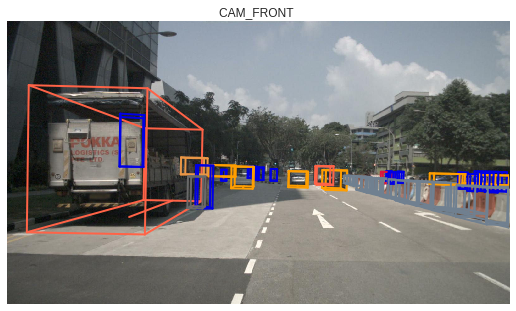

In [17]:
cur_sample = nusc.get('sample', scene['first_sample_token'])
nusc.render_sample_data(cur_sample['data']['CAM_FRONT'])

/home/jhurliman/.local/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/jhurliman/.local/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


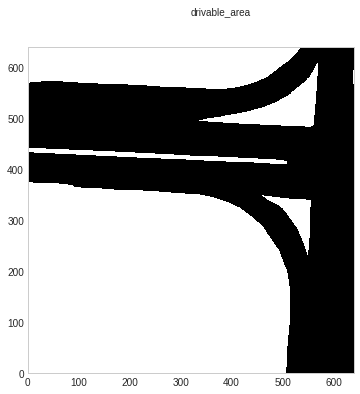

In [18]:
ego_pose = nusc.get('ego_pose', sample_lidar['ego_pose_token'])
translation = ego_pose['translation']
rotation = Quaternion(ego_pose['rotation'])
yaw = quaternion_yaw(rotation) / np.pi * 180
patch_box = (translation[0] - 32, translation[1] - 32, 64, 64)
patch_angle = yaw
canvas_size = (patch_box[2], patch_box[3])

drivable_area = nusc_map.get_map_mask(patch_box, patch_angle, ['drivable_area'], canvas_size)[0]
drivable_area.shape

_ = nusc_map.render_map_mask(patch_box, patch_angle, ['drivable_area'], (640, 640), figsize=(6, 6), n_row=1)

In [126]:
cur_sample = nusc.get('sample', scene['first_sample_token'])

can_parsers = [
    [nusc_can.get_messages(scene_name, 'ms_imu'), 0, get_imu_msg],
    [nusc_can.get_messages(scene_name, 'pose'), 0, get_odom_msg],
    [nusc_can.get_messages(scene_name, 'steeranglefeedback'), 0, lambda x: get_basic_can_msg('Steering Angle', x)],
    [nusc_can.get_messages(scene_name, 'vehicle_monitor'), 0, lambda x: get_basic_can_msg('Vehicle Monitor', x)],
    [nusc_can.get_messages(scene_name, 'zoesensors'), 0, lambda x: get_basic_can_msg('Zoe Sensors', x)],
    [nusc_can.get_messages(scene_name, 'zoe_veh_info'), 0, lambda x: get_basic_can_msg('Zoe Vehicle Info', x)],
]

published_samples = set()
bag = rosbag.Bag('out.bag', 'w', compression='bz2')

stamp = get_time(nusc.get('ego_pose', nusc.get('sample_data', cur_sample['data']['LIDAR_TOP'])['ego_pose_token']))
map_msg = get_scene_map(scene, stamp)
centerlines_msg = get_centerline_markers(scene, stamp)
bag.write('/map', map_msg, stamp)
bag.write('/semantic_map', centerlines_msg, stamp)
last_map_stamp = stamp

while cur_sample is not None:
    sample_lidar = nusc.get('sample_data', cur_sample['data']['LIDAR_TOP'])
    ego_pose = nusc.get('ego_pose', sample_lidar['ego_pose_token'])
    stamp = get_time(ego_pose)

    # write map topics every two seconds
    if stamp - rospy.Duration(2.0) >= last_map_stamp:
        map_msg.header.stamp = stamp
        for marker in centerlines_msg.markers:
            marker.header.stamp = stamp
        bag.write('/map', map_msg, stamp)
        bag.write('/semantic_map', centerlines_msg, stamp)
        last_map_stamp = stamp

    # write CAN messages to /pose, /odom, and /diagnostics
    can_msg_events = []
    for i in range(len(can_parsers)):
        (can_msgs, index, msg_func) = can_parsers[i]
        while index < len(can_msgs) and get_utime(can_msgs[index]) < stamp:
            can_msg_events.append(msg_func(can_msgs[index]))
            index += 1
            can_parsers[i][1] = index
    can_msg_events.sort(key = lambda x: x[0])
    for (msg_stamp, topic, msg) in can_msg_events:
        bag.write(topic, msg, msg_stamp)

    tf_array = TFMessage()

    # create ego transform
    ego_tf = TransformStamped()
    ego_tf.header.frame_id = 'map'
    ego_tf.header.stamp = stamp
    ego_tf.child_frame_id = 'base_link'
    ego_tf.transform = get_transform(ego_pose)
    tf_array.transforms.append(ego_tf)

    # /driveable_area occupancy grid
    write_occupancy_grid(bag, ego_pose, stamp)

    # iterate sensors
    for (sensor_id, sample_token) in cur_sample['data'].items():
        sample_data = nusc.get('sample_data', sample_token)

        # write the sensor data
        if sample_data['sensor_modality'] == 'radar':
            write_radar(bag, sample_data, sensor_id, '/' + sensor_id, stamp)
        elif sample_data['sensor_modality'] == 'lidar':
            write_lidar(bag, sample_data, sensor_id, '/' + sensor_id, stamp)
        elif sample_data['sensor_modality'] == 'camera':
            write_camera(bag, sample_data, sensor_id, '/' + sensor_id, stamp)

        # create sensor transform
        sensor_tf = TransformStamped()
        sensor_tf.header.frame_id = 'base_link'
        sensor_tf.header.stamp = get_time(sample_data)
        sensor_tf.child_frame_id = sensor_id
        sensor_tf.transform = get_transform(
            nusc.get('calibrated_sensor', sample_data['calibrated_sensor_token']))
        tf_array.transforms.append(sensor_tf)

        if sample_data['sensor_modality'] == 'camera':
            write_lidar_imagemarkers(bag, sample_lidar, sample_data, sensor_id, '/' + sensor_id, stamp)
            write_boxes_imagemarkers(bag, cur_sample['anns'], sample_data, sensor_id, '/' + sensor_id, stamp)

    # publish /tf
    bag.write('/tf', tf_array, stamp)

    # publish /markers/ego
    ego = Marker()
    ego.header.frame_id = 'base_link'
    ego.header.stamp = stamp
    ego.id = 0
    ego.type = Marker.MESH_RESOURCE
    ego.pose.orientation.w = 1.0
    ego.frame_locked = True
    ego.scale.x = 1.0
    ego.scale.y = 1.0
    ego.scale.z = 1.0
    ego.mesh_resource = 'https://jhurliman.s3.amazonaws.com/motional-car01.glb'
    bag.write('/markers/ego', ego, stamp)

    pose_stamped = PoseStamped()
    pose_stamped.header.frame_id = 'base_link'
    pose_stamped.header.stamp = stamp
    pose_stamped.pose.orientation.w = 1
    bag.write('/pose', pose_stamped, stamp)

    # publish /gps
    coordinates = derive_latlon(location, ego_pose)
    gps = NavSatFix()
    gps.header.frame_id = 'base_link'
    gps.header.stamp = stamp
    gps.status.status = 1
    gps.status.service = 1
    gps.latitude = coordinates['latitude']
    gps.longitude = coordinates['longitude']
    gps.altitude = ego_tf.transform.translation.z
    bag.write('/gps', gps, stamp)

    if (cur_sample['token'] not in published_samples):
        published_samples.add(cur_sample['token'])

        # publish /markers/annotations
        marker_array = MarkerArray()
        for annotation_id in cur_sample['anns']:
            ann = nusc.get('sample_annotation', annotation_id)
            marker_id = int(ann['instance_token'][:4], 16)
            c = np.array(nusc.explorer.get_color(ann['category_name'])) / 255.0

            marker = Marker()
            marker.header.frame_id = 'map'
            marker.header.stamp = stamp
            marker.id = marker_id
            marker.text = ann['instance_token'][:4]
            marker.type = Marker.CUBE
            marker.pose = get_pose(ann)
            marker.frame_locked = True
            marker.scale.x = ann['size'][1]
            marker.scale.y = ann['size'][0]
            marker.scale.z = ann['size'][2]
            marker.color = make_color(c, 0.5)
            marker_array.markers.append(marker)
        bag.write('/markers/annotations', marker_array, stamp)

    cur_sample = nusc.get('sample', cur_sample['next']) if cur_sample.get('next') != '' else None

bag.close()
print('success')

/home/jhurliman/.local/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/jhurliman/.local/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


success
